Сначала нужно определить какие столбцы мы хотим загрузить из нашей таблицы. 

Так, для моего примера мне нужны столбцы Volume(unit)(2), SurfaceArea (um2)(5) + количество строк.

Шаг1. Извлечение данных из xlsx в df, с которыми я смогу работать в python

glob - показывает пути к файлам с указанным расширением и сохраняет в переменную filepaths

In [26]:
from IPython import get_ipython
get_ipython().magic('reset -sf') 

import pandas as pd
import numpy as np
import glob

Функция csv_to_xlsx трансформирует все файлы csv в папке, затем создает xlsx для каждого файла

In [27]:
def csv_to_xlsx():
    csv_search_string = '**/*.csv'
    csv_filepaths = glob.glob(csv_search_string, recursive=True)
    df = pd.DataFrame()
    for csv in csv_filepaths:
        out = csv.split('.')[0]+'.xlsx'
        df = pd.read_csv(csv, sep=';', encoding='latin1',engine='python')
        df = df.to_excel(out, float_format="%.4f")
    return (df)
csv_to_xlsx()

создаем пустой датафрейм, куда будут загружаться считанные столбики таблиц

в цикле объединяем датафреймы из считанных файлов 

Нужно изменить названия столбцов,чтобы было очевидно их происхождение из другого файла. 

Для этого была написана функция columns_rename, где в цикле добавляется порядковый номер файла, из которого происходило извлечение


Далее заменяем измененным названиями столбцов действующие названия в датафрейме.

In [28]:
def file_extraction(search_string, N, stack_num): 
    filepaths = glob.glob(search_string, recursive=True) #можно изменять номера в N1*stack1,чтобы извлечь другие файлы
    df = pd.DataFrame()
    for find_files in filepaths:
        df = df.join (pd.read_excel(find_files, usecols=[2,5]), how='outer',lsuffix=' ')
    
    columns_names = [j for j in df.columns.tolist()]

    def columns_rename(columns_names):
        j=1
        for i in range (0, len(columns_names), 2):
            columns_names[i] = 'N' + str(N) + '_stack' + str(stack_num) + '_cell' +  str(j)+ '_' + columns_names[i] #можно изменять номера в N1*stack1,чтобы отметить 
            columns_names[i+1] = 'N' + str(N) + '_stack' + str(stack_num) + '_cell' +  str(j)+ '_'  + columns_names[i+1] # принадлежность к другой партии данных
            j+=1
        return(columns_names)
    df.set_axis(columns_rename(columns_names), axis=1, inplace=True)
    return(df)

Извлекаем в отдельные датафреймы все файлы по стекам

In [29]:
N1_stack1 = file_extraction('**/N1*stack1*.xlsx', 1, 1)
N1_stack2 = file_extraction('**/N1*stack2*.xlsx', 1, 2)

N2_stack1 = file_extraction('**/N2*stack1*.xlsx', 2, 1)
N2_stack2 = file_extraction('**/N2*stack2*.xlsx', 2, 2)
N2_stack3 = file_extraction('**/N2*stack3*.xlsx', 2, 3)
N2_stack4 = file_extraction('**/N2*stack4*.xlsx', 2, 4)


Посмотрим на значения основных критериев описательной статистики

In [30]:
N1_stack1.describe()

,N1_stack1_cell1_Volume (unit),N1_stack1_cell1_SurfaceArea,N1_stack1_cell2_Volume (unit),N1_stack1_cell2_SurfaceArea
count,3818.000000,3818.000000,3.901000e+03,3.901000e+03
mean,0.424083,4.567595,3.209620e+02,1.055825e+04
std,0.270616,2.123705,2.002293e+04,1.385439e+05
min,0.010700,0.333800,1.070000e-02,3.338000e-01
25%,0.225600,2.992800,2.041000e-01,2.736300e+00
50%,0.372400,4.350700,3.258000e-01,3.809700e+00
75%,0.572900,5.906700,5.013000e-01,5.185800e+00
max,2.842800,17.403700,1.250592e+06,2.902219e+06


Извлекаем отдельно столбцы, анализ которых будем выполнять.
из-за присутствия NaN не считает перцентили. ПОдумать как это можно разрешить

In [31]:
N11_cell_volume = N1_stack1.iloc[:, 0:4:2].copy()
N11_cell_surf = N1_stack1.iloc[:, 1:4:2].copy()

N11_cell_volume2 = N11_cell_volume.fillna('')
q25, q75 = np.percentile(N11_cell_volume2.iloc[:, 0],[.25,.75])

TypeError: '<' not supported between instances of 'str' and 'float'

Построим графики, чтобы лучше понять данные

Freedman–Diaconis number of bins: N1_stack1_cell1_Volume (unit)    NaN
N1_stack1_cell2_Volume (unit)    NaN
dtype: float64


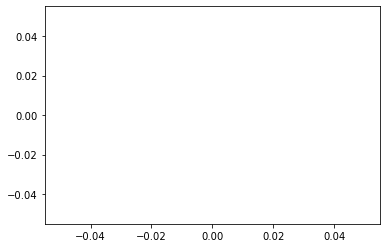

In [ ]:
import matplotlib.pyplot as plt
q25, q75 = np.percentile(N1_stack1.iloc[:, 0:4:2],[.25,.75])
bin_width = 2*(q75 - q25)*len(N11_cell_volume)**(-1/3)
bins = round((N11_cell_volume.max() - N11_cell_volume.min())/bin_width)
print("Freedman–Diaconis number of bins:", bins)
plt.hist(N11_cell_volume, bins = bins);

#plt.hist(N1_stack1.iloc[:, 0:4:2], density=True, bins = bins)  
plt.show()